In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue, VerticalFlip, IAASharpen,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

In [4]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    
    masks = np.zeros((256, 1600, 5), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)
#     print(labels)
    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
#     mask = np.zeros(256 * 1600, dtype=np.uint8)
#     masks[:,:,4] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [5]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
#         print(img.shape, mask.shape)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
#         print(img.shape)
        mask = augmented['mask'] # 1x256x1600x4
#         print(mask.shape)
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


    
    
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.25), # only horizontal flip as of now
                VerticalFlip(p=0.25),
                OneOf([
                    RandomBrightness(),
                    IAASharpen(),
#                     ElasticTransform(alpha=50, sigma=5),
                ], p=0.3)
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [6]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [7]:
IMAGE_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGE_RGB_STD  = [0.229, 0.224, 0.225]



###############################################################################
CONVERSION_34=[
 'block0.0.weight',     (64, 3, 7, 7),   'conv1.weight',        (64, 3, 7, 7),
 'block0.1.weight',     (64,),   'bn1.weight',  (64,),
 'block0.1.bias',       (64,),   'bn1.bias',    (64,),
 'block0.1.running_mean',       (64,),   'bn1.running_mean',    (64,),
 'block0.1.running_var',        (64,),   'bn1.running_var',     (64,),
 'block1.1.conv_bn1.conv.weight',       (64, 64, 3, 3),  'layer1.0.conv1.weight',       (64, 64, 3, 3),
 'block1.1.conv_bn1.bn.weight', (64,),   'layer1.0.bn1.weight', (64,),
 'block1.1.conv_bn1.bn.bias',   (64,),   'layer1.0.bn1.bias',   (64,),
 'block1.1.conv_bn1.bn.running_mean',   (64,),   'layer1.0.bn1.running_mean',   (64,),
 'block1.1.conv_bn1.bn.running_var',    (64,),   'layer1.0.bn1.running_var',    (64,),
 'block1.1.conv_bn2.conv.weight',       (64, 64, 3, 3),  'layer1.0.conv2.weight',       (64, 64, 3, 3),
 'block1.1.conv_bn2.bn.weight', (64,),   'layer1.0.bn2.weight', (64,),
 'block1.1.conv_bn2.bn.bias',   (64,),   'layer1.0.bn2.bias',   (64,),
 'block1.1.conv_bn2.bn.running_mean',   (64,),   'layer1.0.bn2.running_mean',   (64,),
 'block1.1.conv_bn2.bn.running_var',    (64,),   'layer1.0.bn2.running_var',    (64,),
 'block1.2.conv_bn1.conv.weight',       (64, 64, 3, 3),  'layer1.1.conv1.weight',       (64, 64, 3, 3),
 'block1.2.conv_bn1.bn.weight', (64,),   'layer1.1.bn1.weight', (64,),
 'block1.2.conv_bn1.bn.bias',   (64,),   'layer1.1.bn1.bias',   (64,),
 'block1.2.conv_bn1.bn.running_mean',   (64,),   'layer1.1.bn1.running_mean',   (64,),
 'block1.2.conv_bn1.bn.running_var',    (64,),   'layer1.1.bn1.running_var',    (64,),
 'block1.2.conv_bn2.conv.weight',       (64, 64, 3, 3),  'layer1.1.conv2.weight',       (64, 64, 3, 3),
 'block1.2.conv_bn2.bn.weight', (64,),   'layer1.1.bn2.weight', (64,),
 'block1.2.conv_bn2.bn.bias',   (64,),   'layer1.1.bn2.bias',   (64,),
 'block1.2.conv_bn2.bn.running_mean',   (64,),   'layer1.1.bn2.running_mean',   (64,),
 'block1.2.conv_bn2.bn.running_var',    (64,),   'layer1.1.bn2.running_var',    (64,),
 'block1.3.conv_bn1.conv.weight',       (64, 64, 3, 3),  'layer1.2.conv1.weight',       (64, 64, 3, 3),
 'block1.3.conv_bn1.bn.weight', (64,),   'layer1.2.bn1.weight', (64,),
 'block1.3.conv_bn1.bn.bias',   (64,),   'layer1.2.bn1.bias',   (64,),
 'block1.3.conv_bn1.bn.running_mean',   (64,),   'layer1.2.bn1.running_mean',   (64,),
 'block1.3.conv_bn1.bn.running_var',    (64,),   'layer1.2.bn1.running_var',    (64,),
 'block1.3.conv_bn2.conv.weight',       (64, 64, 3, 3),  'layer1.2.conv2.weight',       (64, 64, 3, 3),
 'block1.3.conv_bn2.bn.weight', (64,),   'layer1.2.bn2.weight', (64,),
 'block1.3.conv_bn2.bn.bias',   (64,),   'layer1.2.bn2.bias',   (64,),
 'block1.3.conv_bn2.bn.running_mean',   (64,),   'layer1.2.bn2.running_mean',   (64,),
 'block1.3.conv_bn2.bn.running_var',    (64,),   'layer1.2.bn2.running_var',    (64,),

 'block2.0.conv_bn1.conv.weight',       (128, 64, 3, 3),         'layer2.0.conv1.weight',       (128, 64, 3, 3),
 'block2.0.conv_bn1.bn.weight', (128,),  'layer2.0.bn1.weight', (128,),
 'block2.0.conv_bn1.bn.bias',   (128,),  'layer2.0.bn1.bias',   (128,),
 'block2.0.conv_bn1.bn.running_mean',   (128,),  'layer2.0.bn1.running_mean',   (128,),
 'block2.0.conv_bn1.bn.running_var',    (128,),  'layer2.0.bn1.running_var',    (128,),
 'block2.0.conv_bn2.conv.weight',       (128, 128, 3, 3),        'layer2.0.conv2.weight',       (128, 128, 3, 3),
 'block2.0.conv_bn2.bn.weight', (128,),  'layer2.0.bn2.weight', (128,),
 'block2.0.conv_bn2.bn.bias',   (128,),  'layer2.0.bn2.bias',   (128,),
 'block2.0.conv_bn2.bn.running_mean',   (128,),  'layer2.0.bn2.running_mean',   (128,),
 'block2.0.conv_bn2.bn.running_var',    (128,),  'layer2.0.bn2.running_var',    (128,),
 'block2.0.shortcut.conv.weight',       (128, 64, 1, 1),         'layer2.0.downsample.0.weight',        (128, 64, 1, 1),
 'block2.0.shortcut.bn.weight', (128,),  'layer2.0.downsample.1.weight',        (128,),
 'block2.0.shortcut.bn.bias',   (128,),  'layer2.0.downsample.1.bias',  (128,),
 'block2.0.shortcut.bn.running_mean',   (128,),  'layer2.0.downsample.1.running_mean',  (128,),
 'block2.0.shortcut.bn.running_var',    (128,),  'layer2.0.downsample.1.running_var',   (128,),
 'block2.1.conv_bn1.conv.weight',       (128, 128, 3, 3),        'layer2.1.conv1.weight',       (128, 128, 3, 3),
 'block2.1.conv_bn1.bn.weight', (128,),  'layer2.1.bn1.weight', (128,),
 'block2.1.conv_bn1.bn.bias',   (128,),  'layer2.1.bn1.bias',   (128,),
 'block2.1.conv_bn1.bn.running_mean',   (128,),  'layer2.1.bn1.running_mean',   (128,),
 'block2.1.conv_bn1.bn.running_var',    (128,),  'layer2.1.bn1.running_var',    (128,),
 'block2.1.conv_bn2.conv.weight',       (128, 128, 3, 3),        'layer2.1.conv2.weight',       (128, 128, 3, 3),
 'block2.1.conv_bn2.bn.weight', (128,),  'layer2.1.bn2.weight', (128,),
 'block2.1.conv_bn2.bn.bias',   (128,),  'layer2.1.bn2.bias',   (128,),
 'block2.1.conv_bn2.bn.running_mean',   (128,),  'layer2.1.bn2.running_mean',   (128,),
 'block2.1.conv_bn2.bn.running_var',    (128,),  'layer2.1.bn2.running_var',    (128,),

 'block2.2.conv_bn1.conv.weight',       (128, 128, 3, 3),        'layer2.2.conv1.weight',       (128, 128, 3, 3),
 'block2.2.conv_bn1.bn.weight', (128,),  'layer2.2.bn1.weight', (128,),
 'block2.2.conv_bn1.bn.bias',   (128,),  'layer2.2.bn1.bias',   (128,),
 'block2.2.conv_bn1.bn.running_mean',   (128,),  'layer2.2.bn1.running_mean',   (128,),
 'block2.2.conv_bn1.bn.running_var',    (128,),  'layer2.2.bn1.running_var',    (128,),
 'block2.2.conv_bn2.conv.weight',       (128, 128, 3, 3),        'layer2.2.conv2.weight',       (128, 128, 3, 3),
 'block2.2.conv_bn2.bn.weight', (128,),  'layer2.2.bn2.weight', (128,),
 'block2.2.conv_bn2.bn.bias',   (128,),  'layer2.2.bn2.bias',   (128,),
 'block2.2.conv_bn2.bn.running_mean',   (128,),  'layer2.2.bn2.running_mean',   (128,),
 'block2.2.conv_bn2.bn.running_var',    (128,),  'layer2.2.bn2.running_var',    (128,),

 'block2.3.conv_bn1.conv.weight',       (128, 128, 3, 3),        'layer2.3.conv1.weight',       (128, 128, 3, 3),
 'block2.3.conv_bn1.bn.weight', (128,),  'layer2.3.bn1.weight', (128,),
 'block2.3.conv_bn1.bn.bias',   (128,),  'layer2.3.bn1.bias',   (128,),
 'block2.3.conv_bn1.bn.running_mean',   (128,),  'layer2.3.bn1.running_mean',   (128,),
 'block2.3.conv_bn1.bn.running_var',    (128,),  'layer2.3.bn1.running_var',    (128,),
 'block2.3.conv_bn2.conv.weight',       (128, 128, 3, 3),        'layer2.3.conv2.weight',       (128, 128, 3, 3),
 'block2.3.conv_bn2.bn.weight', (128,),  'layer2.3.bn2.weight', (128,),
 'block2.3.conv_bn2.bn.bias',   (128,),  'layer2.3.bn2.bias',   (128,),
 'block2.3.conv_bn2.bn.running_mean',   (128,),  'layer2.3.bn2.running_mean',   (128,),
 'block2.3.conv_bn2.bn.running_var',    (128,),  'layer2.3.bn2.running_var',    (128,),


 'block3.0.conv_bn1.conv.weight',       (256, 128, 3, 3),        'layer3.0.conv1.weight',       (256, 128, 3, 3),
 'block3.0.conv_bn1.bn.weight', (256,),  'layer3.0.bn1.weight', (256,),
 'block3.0.conv_bn1.bn.bias',   (256,),  'layer3.0.bn1.bias',   (256,),
 'block3.0.conv_bn1.bn.running_mean',   (256,),  'layer3.0.bn1.running_mean',   (256,),
 'block3.0.conv_bn1.bn.running_var',    (256,),  'layer3.0.bn1.running_var',    (256,),
 'block3.0.conv_bn2.conv.weight',       (256, 256, 3, 3),        'layer3.0.conv2.weight',       (256, 256, 3, 3),
 'block3.0.conv_bn2.bn.weight', (256,),  'layer3.0.bn2.weight', (256,),
 'block3.0.conv_bn2.bn.bias',   (256,),  'layer3.0.bn2.bias',   (256,),
 'block3.0.conv_bn2.bn.running_mean',   (256,),  'layer3.0.bn2.running_mean',   (256,),
 'block3.0.conv_bn2.bn.running_var',    (256,),  'layer3.0.bn2.running_var',    (256,),
 'block3.0.shortcut.conv.weight',       (256, 128, 1, 1),        'layer3.0.downsample.0.weight',        (256, 128, 1, 1),
 'block3.0.shortcut.bn.weight', (256,),  'layer3.0.downsample.1.weight',        (256,),
 'block3.0.shortcut.bn.bias',   (256,),  'layer3.0.downsample.1.bias',  (256,),
 'block3.0.shortcut.bn.running_mean',   (256,),  'layer3.0.downsample.1.running_mean',  (256,),
 'block3.0.shortcut.bn.running_var',    (256,),  'layer3.0.downsample.1.running_var',   (256,),

 'block3.1.conv_bn1.conv.weight',       (256, 256, 3, 3),        'layer3.1.conv1.weight',       (256, 256, 3, 3),
 'block3.1.conv_bn1.bn.weight', (256,),  'layer3.1.bn1.weight', (256,),
 'block3.1.conv_bn1.bn.bias',   (256,),  'layer3.1.bn1.bias',   (256,),
 'block3.1.conv_bn1.bn.running_mean',   (256,),  'layer3.1.bn1.running_mean',   (256,),
 'block3.1.conv_bn1.bn.running_var',    (256,),  'layer3.1.bn1.running_var',    (256,),
 'block3.1.conv_bn2.conv.weight',       (256, 256, 3, 3),        'layer3.1.conv2.weight',       (256, 256, 3, 3),
 'block3.1.conv_bn2.bn.weight', (256,),  'layer3.1.bn2.weight', (256,),
 'block3.1.conv_bn2.bn.bias',   (256,),  'layer3.1.bn2.bias',   (256,),
 'block3.1.conv_bn2.bn.running_mean',   (256,),  'layer3.1.bn2.running_mean',   (256,),
 'block3.1.conv_bn2.bn.running_var',    (256,),  'layer3.1.bn2.running_var',    (256,),

 'block3.2.conv_bn1.conv.weight',       (256, 256, 3, 3),        'layer3.2.conv1.weight',       (256, 256, 3, 3),
 'block3.2.conv_bn1.bn.weight', (256,),  'layer3.2.bn1.weight', (256,),
 'block3.2.conv_bn1.bn.bias',   (256,),  'layer3.2.bn1.bias',   (256,),
 'block3.2.conv_bn1.bn.running_mean',   (256,),  'layer3.2.bn1.running_mean',   (256,),
 'block3.2.conv_bn1.bn.running_var',    (256,),  'layer3.2.bn1.running_var',    (256,),
 'block3.2.conv_bn2.conv.weight',       (256, 256, 3, 3),        'layer3.2.conv2.weight',       (256, 256, 3, 3),
 'block3.2.conv_bn2.bn.weight', (256,),  'layer3.2.bn2.weight', (256,),
 'block3.2.conv_bn2.bn.bias',   (256,),  'layer3.2.bn2.bias',   (256,),
 'block3.2.conv_bn2.bn.running_mean',   (256,),  'layer3.2.bn2.running_mean',   (256,),
 'block3.2.conv_bn2.bn.running_var',    (256,),  'layer3.2.bn2.running_var',    (256,),

 'block3.3.conv_bn1.conv.weight',       (256, 256, 3, 3),        'layer3.3.conv1.weight',       (256, 256, 3, 3),
 'block3.3.conv_bn1.bn.weight', (256,),  'layer3.3.bn1.weight', (256,),
 'block3.3.conv_bn1.bn.bias',   (256,),  'layer3.3.bn1.bias',   (256,),
 'block3.3.conv_bn1.bn.running_mean',   (256,),  'layer3.3.bn1.running_mean',   (256,),
 'block3.3.conv_bn1.bn.running_var',    (256,),  'layer3.3.bn1.running_var',    (256,),
 'block3.3.conv_bn2.conv.weight',       (256, 256, 3, 3),        'layer3.3.conv2.weight',       (256, 256, 3, 3),
 'block3.3.conv_bn2.bn.weight', (256,),  'layer3.3.bn2.weight', (256,),
 'block3.3.conv_bn2.bn.bias',   (256,),  'layer3.3.bn2.bias',   (256,),
 'block3.3.conv_bn2.bn.running_mean',   (256,),  'layer3.3.bn2.running_mean',   (256,),
 'block3.3.conv_bn2.bn.running_var',    (256,),  'layer3.3.bn2.running_var',    (256,),

 'block3.4.conv_bn1.conv.weight',       (256, 256, 3, 3),        'layer3.4.conv1.weight',       (256, 256, 3, 3),
 'block3.4.conv_bn1.bn.weight', (256,),  'layer3.4.bn1.weight', (256,),
 'block3.4.conv_bn1.bn.bias',   (256,),  'layer3.4.bn1.bias',   (256,),
 'block3.4.conv_bn1.bn.running_mean',   (256,),  'layer3.4.bn1.running_mean',   (256,),
 'block3.4.conv_bn1.bn.running_var',    (256,),  'layer3.4.bn1.running_var',    (256,),
 'block3.4.conv_bn2.conv.weight',       (256, 256, 3, 3),        'layer3.4.conv2.weight',       (256, 256, 3, 3),
 'block3.4.conv_bn2.bn.weight', (256,),  'layer3.4.bn2.weight', (256,),
 'block3.4.conv_bn2.bn.bias',   (256,),  'layer3.4.bn2.bias',   (256,),
 'block3.4.conv_bn2.bn.running_mean',   (256,),  'layer3.4.bn2.running_mean',   (256,),
 'block3.4.conv_bn2.bn.running_var',    (256,),  'layer3.4.bn2.running_var',    (256,),

 'block3.5.conv_bn1.conv.weight',       (256, 256, 3, 3),        'layer3.5.conv1.weight',       (256, 256, 3, 3),
 'block3.5.conv_bn1.bn.weight', (256,),  'layer3.5.bn1.weight', (256,),
 'block3.5.conv_bn1.bn.bias',   (256,),  'layer3.5.bn1.bias',   (256,),
 'block3.5.conv_bn1.bn.running_mean',   (256,),  'layer3.5.bn1.running_mean',   (256,),
 'block3.5.conv_bn1.bn.running_var',    (256,),  'layer3.5.bn1.running_var',    (256,),
 'block3.5.conv_bn2.conv.weight',       (256, 256, 3, 3),        'layer3.5.conv2.weight',       (256, 256, 3, 3),
 'block3.5.conv_bn2.bn.weight', (256,),  'layer3.5.bn2.weight', (256,),
 'block3.5.conv_bn2.bn.bias',   (256,),  'layer3.5.bn2.bias',   (256,),
 'block3.5.conv_bn2.bn.running_mean',   (256,),  'layer3.5.bn2.running_mean',   (256,),
 'block3.5.conv_bn2.bn.running_var',    (256,),  'layer3.5.bn2.running_var',    (256,),

 'block4.0.conv_bn1.conv.weight',       (512, 256, 3, 3),        'layer4.0.conv1.weight',       (512, 256, 3, 3),
 'block4.0.conv_bn1.bn.weight', (512,),  'layer4.0.bn1.weight', (512,),
 'block4.0.conv_bn1.bn.bias',   (512,),  'layer4.0.bn1.bias',   (512,),
 'block4.0.conv_bn1.bn.running_mean',   (512,),  'layer4.0.bn1.running_mean',   (512,),
 'block4.0.conv_bn1.bn.running_var',    (512,),  'layer4.0.bn1.running_var',    (512,),
 'block4.0.conv_bn2.conv.weight',       (512, 512, 3, 3),        'layer4.0.conv2.weight',       (512, 512, 3, 3),
 'block4.0.conv_bn2.bn.weight', (512,),  'layer4.0.bn2.weight', (512,),
 'block4.0.conv_bn2.bn.bias',   (512,),  'layer4.0.bn2.bias',   (512,),
 'block4.0.conv_bn2.bn.running_mean',   (512,),  'layer4.0.bn2.running_mean',   (512,),
 'block4.0.conv_bn2.bn.running_var',    (512,),  'layer4.0.bn2.running_var',    (512,),
 'block4.0.shortcut.conv.weight',       (512, 256, 1, 1),        'layer4.0.downsample.0.weight',        (512, 256, 1, 1),
 'block4.0.shortcut.bn.weight', (512,),  'layer4.0.downsample.1.weight',        (512,),
 'block4.0.shortcut.bn.bias',   (512,),  'layer4.0.downsample.1.bias',  (512,),
 'block4.0.shortcut.bn.running_mean',   (512,),  'layer4.0.downsample.1.running_mean',  (512,),
 'block4.0.shortcut.bn.running_var',    (512,),  'layer4.0.downsample.1.running_var',   (512,),

 'block4.1.conv_bn1.conv.weight',       (512, 512, 3, 3),        'layer4.1.conv1.weight',       (512, 512, 3, 3),
 'block4.1.conv_bn1.bn.weight', (512,),  'layer4.1.bn1.weight', (512,),
 'block4.1.conv_bn1.bn.bias',   (512,),  'layer4.1.bn1.bias',   (512,),
 'block4.1.conv_bn1.bn.running_mean',   (512,),  'layer4.1.bn1.running_mean',   (512,),
 'block4.1.conv_bn1.bn.running_var',    (512,),  'layer4.1.bn1.running_var',    (512,),
 'block4.1.conv_bn2.conv.weight',       (512, 512, 3, 3),        'layer4.1.conv2.weight',       (512, 512, 3, 3),
 'block4.1.conv_bn2.bn.weight', (512,),  'layer4.1.bn2.weight', (512,),
 'block4.1.conv_bn2.bn.bias',   (512,),  'layer4.1.bn2.bias',   (512,),
 'block4.1.conv_bn2.bn.running_mean',   (512,),  'layer4.1.bn2.running_mean',   (512,),
 'block4.1.conv_bn2.bn.running_var',    (512,),  'layer4.1.bn2.running_var',    (512,),

 'block4.2.conv_bn1.conv.weight',       (512, 512, 3, 3),        'layer4.2.conv1.weight',       (512, 512, 3, 3),
 'block4.2.conv_bn1.bn.weight', (512,),  'layer4.2.bn1.weight', (512,),
 'block4.2.conv_bn1.bn.bias',   (512,),  'layer4.2.bn1.bias',   (512,),
 'block4.2.conv_bn1.bn.running_mean',   (512,),  'layer4.2.bn1.running_mean',   (512,),
 'block4.2.conv_bn1.bn.running_var',    (512,),  'layer4.2.bn1.running_var',    (512,),
 'block4.2.conv_bn2.conv.weight',       (512, 512, 3, 3),        'layer4.2.conv2.weight',       (512, 512, 3, 3),
 'block4.2.conv_bn2.bn.weight', (512,),  'layer4.2.bn2.weight', (512,),
 'block4.2.conv_bn2.bn.bias',   (512,),  'layer4.2.bn2.bias',   (512,),
 'block4.2.conv_bn2.bn.running_mean',   (512,),  'layer4.2.bn2.running_mean',   (512,),
 'block4.2.conv_bn2.bn.running_var',    (512,),  'layer4.2.bn2.running_var',    (512,),

 'logit.weight',        (1000, 512),     'fc.weight',   (1000, 512),
 'logit.bias',  (1000,),         'fc.bias',     (1000,),

]


In [8]:
PRETRAIN_FILE = '../cache/resnet34-333f7ec4.pth'

def load_pretrain(net, skip=[], pretrain_file=PRETRAIN_FILE, conversion=CONVERSION_34, is_print=True):

    #raise NotImplementedError
    print('\tload pretrain_file: %s'%pretrain_file)

    #pretrain_state_dict = torch.load(pretrain_file)
    pretrain_state_dict = torch.load(pretrain_file, map_location=lambda storage, loc: storage)
    state_dict = net.state_dict()

    i = 0
    conversion = np.array(conversion).reshape(-1,4)
    for key,_,pretrain_key,_ in conversion:
        if any(s in key for s in
            ['.num_batches_tracked',]+skip):
            continue

        #print('\t\t',key)
        if is_print:
            print('\t\t','%-48s  %-24s  <---  %-32s  %-24s'%(
                key, str(state_dict[key].shape),
                pretrain_key, str(pretrain_state_dict[pretrain_key].shape),
            ))
        i = i+1

        state_dict[key] = pretrain_state_dict[pretrain_key]

    net.load_state_dict(state_dict)
    print('')
    print('len(pretrain_state_dict.keys()) = %d'%len(pretrain_state_dict.keys()))
    print('len(state_dict.keys())          = %d'%len(state_dict.keys()))
    print('loaded    = %d'%i)
    print('')



In [9]:
###############################################################################
class ConvBn2d(nn.Module):

    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, stride=1):
        super(ConvBn2d, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn   = nn.BatchNorm2d(out_channel, eps=1e-5)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return x




#############  resnext50 pyramid feature net #######################################
# https://github.com/Hsuxu/ResNeXt/blob/master/models.py
# https://github.com/D-X-Y/ResNeXt-DenseNet/blob/master/models/resnext.py
# https://github.com/miraclewkf/ResNeXt-PyTorch/blob/master/resnext.py


# bottleneck type C
class BasicBlock(nn.Module):
    def __init__(self, in_channel, channel, out_channel, stride=1, is_shortcut=False):
        super(BasicBlock, self).__init__()
        self.is_shortcut = is_shortcut

        self.conv_bn1 = ConvBn2d(in_channel,    channel, kernel_size=3, padding=1, stride=stride)
        self.conv_bn2 = ConvBn2d(   channel,out_channel, kernel_size=3, padding=1, stride=1)

        if is_shortcut:
            self.shortcut = ConvBn2d(in_channel, out_channel, kernel_size=1, padding=0, stride=stride)


    def forward(self, x):
        z = F.relu(self.conv_bn1(x),inplace=True)
        z = self.conv_bn2(z)

        if self.is_shortcut:
            x = self.shortcut(x)

        z += x
        z = F.relu(z,inplace=True)
        return z



In [10]:
#resnet34
class ResNet34(nn.Module):

    def __init__(self, num_class=1000 ):
        super(ResNet34, self).__init__()


        self.block0  = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
            BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.block1  = nn.Sequential(
             nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
             BasicBlock( 64, 64, 64, stride=1, is_shortcut=False,),
          * [BasicBlock( 64, 64, 64, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.block2  = nn.Sequential(
             BasicBlock( 64,128,128, stride=2, is_shortcut=True, ),
          * [BasicBlock(128,128,128, stride=1, is_shortcut=False,) for i in range(1,4)],
        )
        self.block3  = nn.Sequential(
             BasicBlock(128,256,256, stride=2, is_shortcut=True, ),
          * [BasicBlock(256,256,256, stride=1, is_shortcut=False,) for i in range(1,6)],
        )
        self.block4 = nn.Sequential(
             BasicBlock(256,512,512, stride=2, is_shortcut=True, ),
          * [BasicBlock(512,512,512, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.logit = nn.Linear(512,num_class)



    def forward(self, x):
        batch_size = len(x)

        x = self.block0(x)
        x = F.max_pool2d(x,kernel_size=3, padding=1, stride=2, ceil_mode=False)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)
        return logit


In [11]:
def upsize(x,scale_factor=2):
    #x = F.interpolate(x, size=e.shape[2:], mode='nearest')
    x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
    return x

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Decode(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Decode, self).__init__()

        self.top = nn.Sequential(
            nn.Conv2d(in_channel, out_channel//2, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNorm2d( out_channel//2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.1),

            nn.Conv2d(out_channel//2, out_channel//2, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNorm2d(out_channel//2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.1),

            nn.Conv2d(out_channel//2, out_channel, kernel_size=1, stride=1, padding=0, bias=False),
            BatchNorm2d(out_channel),
            nn.ReLU(inplace=True), #Swish(), #
        )

    def forward(self, x):
        x = self.top(torch.cat(x, 1))
        return x


In [12]:
BatchNorm2d = nn.BatchNorm2d
class Net(nn.Module):

    def load_pretrain(self, skip, is_print=True):
        conversion=copy.copy(CONVERSION_34)
        for i in range(0,len(conversion)-8,4):
            conversion[i] = 'block.' + conversion[i][5:]
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=conversion, is_print=is_print)

    def __init__(self, num_class=5, drop_connect_rate=0.2):
        super(Net, self).__init__()

        e = ResNet34()
        self.block = nn.ModuleList([
           e.block0,
           e.block1,
           e.block2,
           e.block3,
           e.block4
        ])
        e = None  #dropped

        self.decode1 =  Decode(512,     128)
        self.decode2 =  Decode(128+256, 128)
        self.decode3 =  Decode(128+128, 128)
        self.decode4 =  Decode(128+ 64, 128)
        self.decode5 =  Decode(128+ 64, 128)
        self.logit = nn.Conv2d(128,num_class, kernel_size=1)

    def forward(self, x):
        batch_size,C,H,W = x.shape

        #----------------------------------
        backbone = []
        for i in range( len(self.block)):
            x = self.block[i](x)
            #print(i, x.shape)

            if i in [0,1,2,3,4]:
                backbone.append(x)

        #----------------------------------
        x = self.decode1([backbone[-1], ])                   #; print('d1',d1.size())
        x = self.decode2([backbone[-2], upsize(x)])          #; print('d2',d2.size())
        x = self.decode3([backbone[-3], upsize(x)])          #; print('d3',d3.size())
        x = self.decode4([backbone[-4], upsize(x)])          #; print('d4',d4.size())
        x = self.decode5([backbone[-5], upsize(x)])          #; print('d5',d5.size())

        logit = self.logit(x)
        logit = F.interpolate(logit, size=(H,W), mode='bilinear', align_corners=False)
        return logit


In [13]:
# def criterion(logit, truth, weight=None):
#     logit = logit.permute(0, 2, 3, 1).contiguous().view(-1, 5)
#     truth = truth.permute(0, 2, 3, 1).contiguous().view(-1)

#     if weight is not None: weight = torch.FloatTensor([1]+weight).cuda()
#     loss = F.cross_entropy(logit, truth, weight=weight, reduction='none')

#     loss = loss.mean()
#     return loss


In [14]:
import copy
model = Net()

model.load_pretrain(skip=['logit'], is_print=False)

	load pretrain_file: ../cache/resnet34-333f7ec4.pth

len(pretrain_state_dict.keys()) = 182
len(state_dict.keys())          = 308
loaded    = 180



In [15]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": 8, "val": 8}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 3e-4
        self.num_epochs = 35
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [16]:
sample_submission_path = '../data/sample_submission.csv'
train_df_path = '../data/train.csv'
data_folder = "../data/"
test_data_folder = "../data/test_images"


In [17]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 23:59:44
Loss: 0.1627 | IoU: 0.0902 | dice: 0.4066 | dice_neg: 0.7396 | dice_pos: 0.1239
Starting epoch: 0 | phase: val | ⏰: 00:14:31
Loss: 0.0413 | IoU: 0.3050 | dice: 0.5556 | dice_neg: 0.7331 | dice_pos: 0.3938
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 00:16:55
Loss: 0.0296 | IoU: 0.2933 | dice: 0.5689 | dice_neg: 0.8065 | dice_pos: 0.3785
Starting epoch: 1 | phase: val | ⏰: 00:31:41
Loss: 0.0198 | IoU: 0.3265 | dice: 0.6546 | dice_neg: 0.9161 | dice_pos: 0.4130
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 00:34:03
Loss: 0.0184 | IoU: 0.3350 | dice: 0.6017 | dice_neg: 0.8148 | dice_pos: 0.4303
Starting epoch: 2 | phase: val | ⏰: 00:48:39
Loss: 0.0147 | IoU: 0.4284 | dice: 0.6526 | dice_neg: 0.7816 | dice_pos: 0.5352
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 00:51:01
Loss: 0.0149 | IoU: 0.3691 | dice: 0.6287 | 

Loss: 0.0084 | IoU: 0.5572 | dice: 0.7856 | dice_neg: 0.8935 | dice_pos: 0.6739
Epoch    29: reducing learning rate of group 0 to 3.0000e-05.

Starting epoch: 30 | phase: train | ⏰: 08:33:54
Loss: 0.0052 | IoU: 0.6204 | dice: 0.8307 | dice_neg: 0.9347 | dice_pos: 0.7329
Starting epoch: 30 | phase: val | ⏰: 08:48:41
Loss: 0.0082 | IoU: 0.5581 | dice: 0.7910 | dice_neg: 0.9059 | dice_pos: 0.6749

Starting epoch: 31 | phase: train | ⏰: 08:51:02
Loss: 0.0049 | IoU: 0.6314 | dice: 0.8390 | dice_neg: 0.9361 | dice_pos: 0.7446
Starting epoch: 31 | phase: val | ⏰: 09:05:52
Loss: 0.0083 | IoU: 0.5678 | dice: 0.7885 | dice_neg: 0.8980 | dice_pos: 0.6872

Starting epoch: 32 | phase: train | ⏰: 09:08:14
Loss: 0.0048 | IoU: 0.6365 | dice: 0.8420 | dice_neg: 0.9337 | dice_pos: 0.7493
Starting epoch: 32 | phase: val | ⏰: 09:23:04
Loss: 0.0084 | IoU: 0.5542 | dice: 0.7965 | dice_neg: 0.9192 | dice_pos: 0.6751

Starting epoch: 33 | phase: train | ⏰: 09:25:24
Loss: 0.0048 | IoU: 0.6416 | dice: 0.8453 | 

In [ ]:
# 9 * 60/ 23

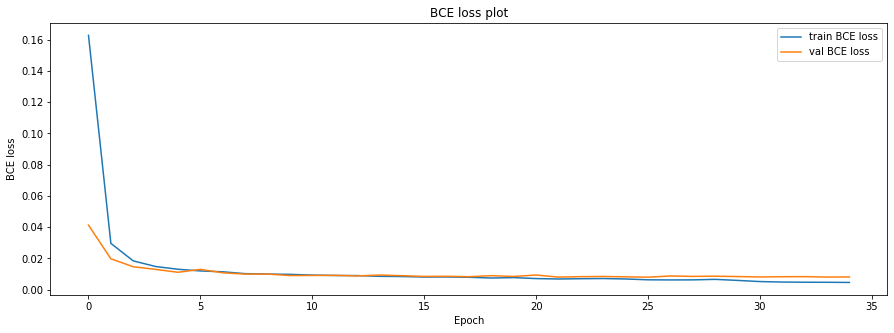

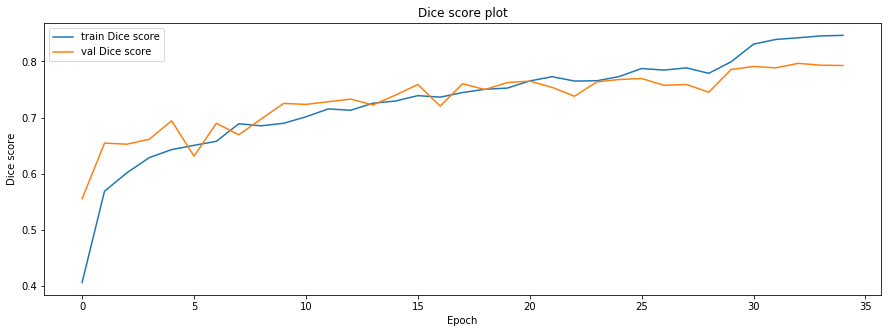

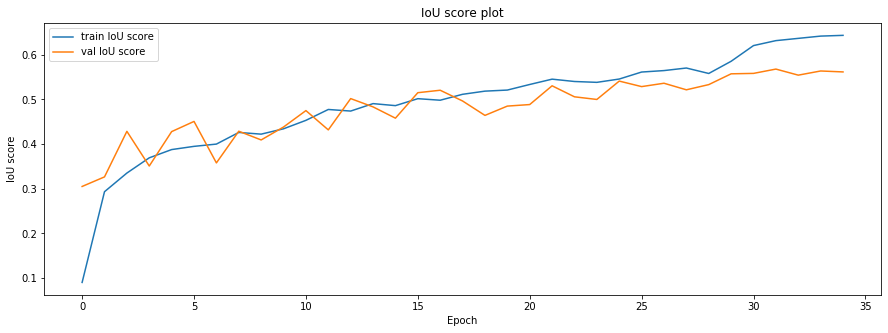

In [18]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

In [11]:
from mlcomp.utils.describe import describe, describe_task_names
describe_task_names(dag=5)

,id,name
0,21,preprocess
1,22,masks
2,23,encoder=resnet34
3,24,encoder=se_resnext50_32x4d batch_size=8
4,25,model_params/model=MobileUnet model_params/input_size=256 model_params/pretrained=True model_params/num_classes=4


2019-10-21 04:25:13.704582
Task = 22. Status = 6, before the execute_by_id invocation. Request Id = 89ea9c83-3388-4996-9a49-a18f9ae63fa3


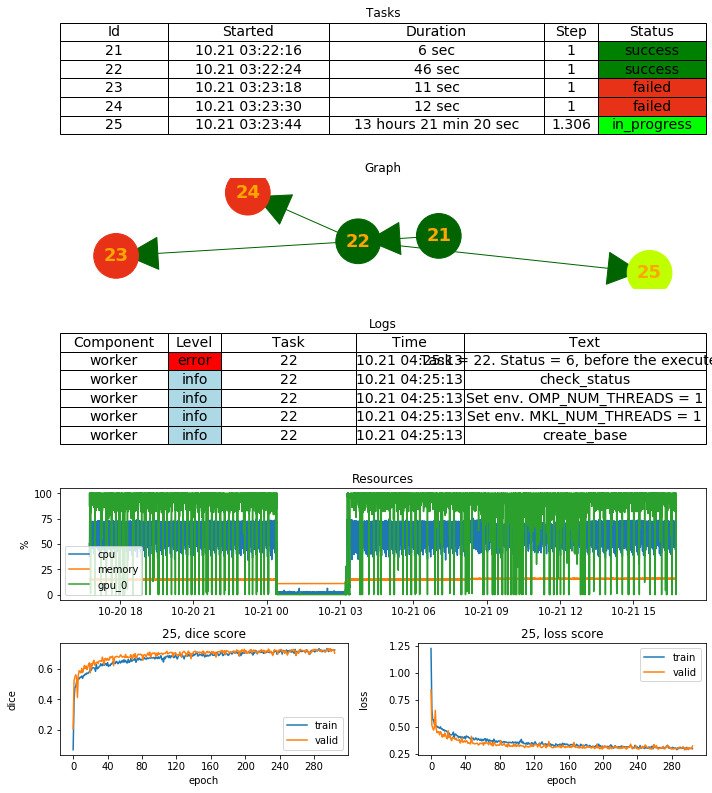

In [ ]:
describe(dag=5, metrics=['loss', 'dice'], wait=True, task_with_metric_count=3, fig_size=(10 ,15))